# US House Market Prediction

In [117]:
import math
import warnings

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchinfo
import torchmetrics
from geopy.geocoders import Nominatim
from sklearn.preprocessing import RobustScaler
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split

warnings.filterwarnings('ignore')

## Data Loading

In [118]:
df = pd.read_csv('datasets/realtordataUS.csv', encoding='UTF-8')
df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2226377,23009.0,sold,359900.0,4.0,2.0,0.33,353094.0,Richland,Washington,99354.0,3600.0,2022-03-25
2226378,18208.0,sold,350000.0,3.0,2.0,0.10,1062149.0,Richland,Washington,99354.0,1616.0,2022-03-25
2226379,76856.0,sold,440000.0,6.0,3.0,0.50,405677.0,Richland,Washington,99354.0,3200.0,2022-03-24
2226380,53618.0,sold,179900.0,2.0,1.0,0.09,761379.0,Richland,Washington,99354.0,933.0,2022-03-24


### Null/Missing Values Check

In [119]:
df.isnull().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

### Statistics of Dataset

In [120]:
df.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2.221849e+06,2.224841e+06,1.745065e+06,1.714611e+06,1.900793e+06,2.215516e+06,2.226083e+06,1.657898e+06
mean,5.293989e+04,5.241955e+05,3.275841e+00,2.496440e+00,1.522303e+01,1.012325e+06,5.218668e+04,2.714471e+03
std,3.064275e+04,2.138893e+06,1.567274e+00,1.652573e+00,7.628238e+02,5.837635e+05,2.895408e+04,8.081635e+05
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
25%,2.386100e+04,1.650000e+05,3.000000e+00,2.000000e+00,1.500000e-01,5.063128e+05,2.961700e+04,1.300000e+03
50%,5.288400e+04,3.250000e+05,3.000000e+00,2.000000e+00,2.600000e-01,1.012766e+06,4.838200e+04,1.760000e+03
75%,7.918300e+04,5.500000e+05,4.000000e+00,3.000000e+00,9.800000e-01,1.521173e+06,7.807000e+04,2.413000e+03
max,1.101420e+05,2.147484e+09,4.730000e+02,8.300000e+02,1.000000e+05,2.001357e+06,9.999900e+04,1.040400e+09


## Data Cleaning

First we will drop all unncessary columns in the dataset

In [121]:
df = df.drop(columns=["brokered_by", "status", "street", "prev_sold_date"])
df

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
4,65000.0,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN
...,...,...,...,...,...,...,...,...
2226377,359900.0,4.0,2.0,0.33,Richland,Washington,99354.0,3600.0
2226378,350000.0,3.0,2.0,0.10,Richland,Washington,99354.0,1616.0
2226379,440000.0,6.0,3.0,0.50,Richland,Washington,99354.0,3200.0
2226380,179900.0,2.0,1.0,0.09,Richland,Washington,99354.0,933.0


We will also drop all null values present in the dataset since there are tons from the Null Value Check

In [122]:
df = df.dropna()
df

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
5,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612.0,2520.0
...,...,...,...,...,...,...,...,...
2226377,359900.0,4.0,2.0,0.33,Richland,Washington,99354.0,3600.0
2226378,350000.0,3.0,2.0,0.10,Richland,Washington,99354.0,1616.0
2226379,440000.0,6.0,3.0,0.50,Richland,Washington,99354.0,3200.0
2226380,179900.0,2.0,1.0,0.09,Richland,Washington,99354.0,933.0


We also want to drop all duplicate rows if there are any.

In [123]:
df = df.drop_duplicates()
df

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
5,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612.0,2520.0
...,...,...,...,...,...,...,...,...
2226377,359900.0,4.0,2.0,0.33,Richland,Washington,99354.0,3600.0
2226378,350000.0,3.0,2.0,0.10,Richland,Washington,99354.0,1616.0
2226379,440000.0,6.0,3.0,0.50,Richland,Washington,99354.0,3200.0
2226380,179900.0,2.0,1.0,0.09,Richland,Washington,99354.0,933.0


We also want to remove outliers such as houses with 10 or more bedrooms/bathrooms (these could be buildings, multi-family residentals, extreme luxary mansions, or data entry errors)

In [124]:
df = df[(df['bed'] < 10) & (df['bath'] < 10) & (df['price'] > 50000) & (df['price'] < 50000000)]
df

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
5,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612.0,2520.0
...,...,...,...,...,...,...,...,...
2226377,359900.0,4.0,2.0,0.33,Richland,Washington,99354.0,3600.0
2226378,350000.0,3.0,2.0,0.10,Richland,Washington,99354.0,1616.0
2226379,440000.0,6.0,3.0,0.50,Richland,Washington,99354.0,3200.0
2226380,179900.0,2.0,1.0,0.09,Richland,Washington,99354.0,933.0


## Visualization & Exploratory Data Analysis

Lets first see the count of all priced houses. If we do it regularly its incredibly difficult to see due to the outliers and they dominate the scale of our plot. We can then use a logarithmic scale to further see the relationships.

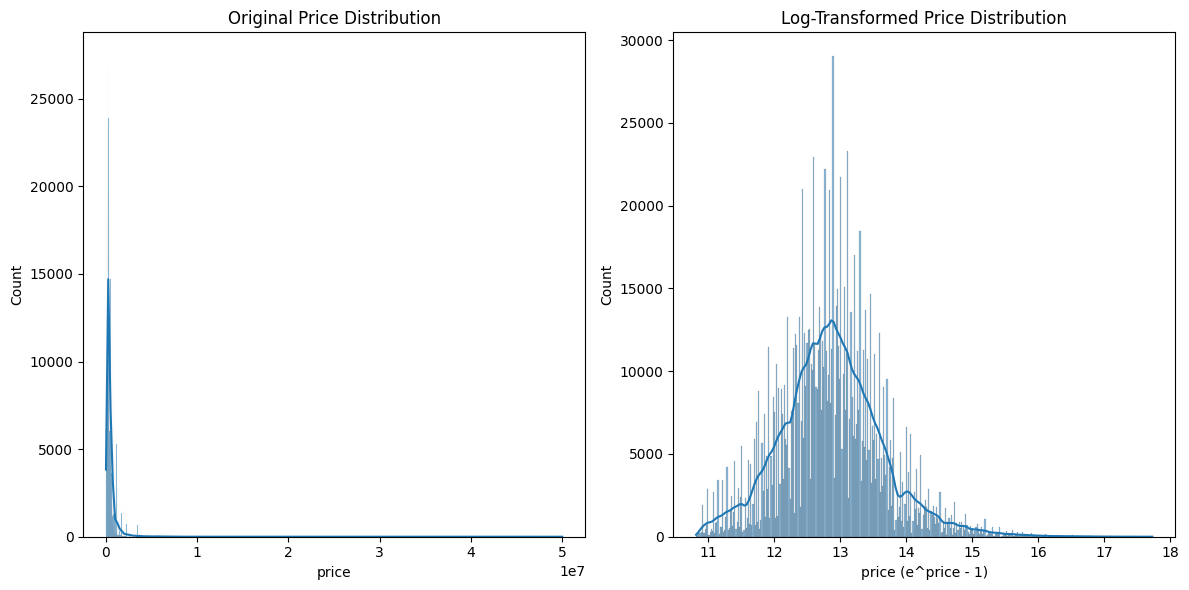

In [125]:
# Apply log transformation to Price
prices = np.log1p(df['price'])  # log1p handles log(1 + x), avoiding log(0)

# Visualize the original and transformed distributions
plt.figure(figsize=(12, 6))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Original Price Distribution')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(prices, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.xlabel("price (e^price - 1)")

plt.tight_layout()
plt.show()

We can also plot this dataset using a heat map to show the correlation matrix of all numerical features.

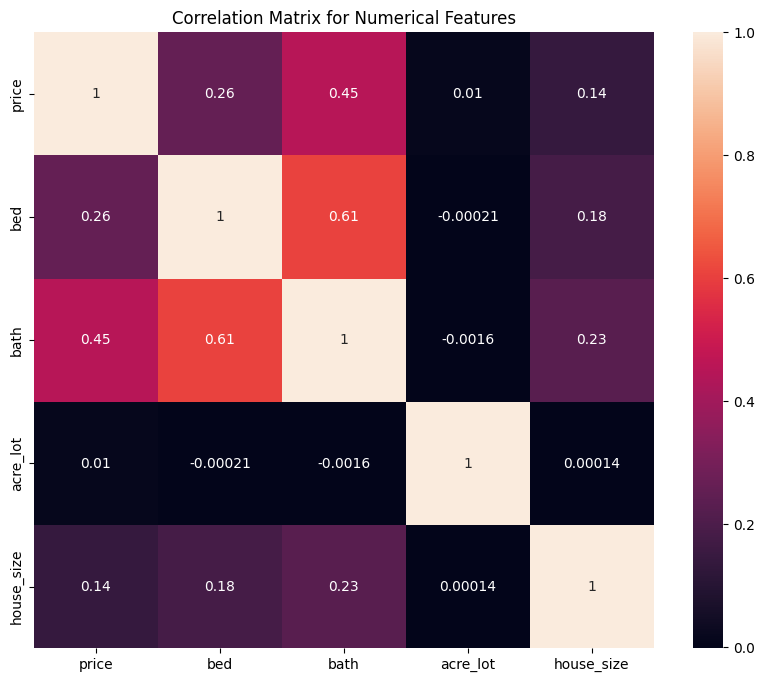

In [126]:
# Compute the correlation matrix
corr_columns = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
corr_matrix = df[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

Here is the correlation graphings and the pairplots for all features as well. These are also log-scaled due to the extreme outlier situation we faced earlier.

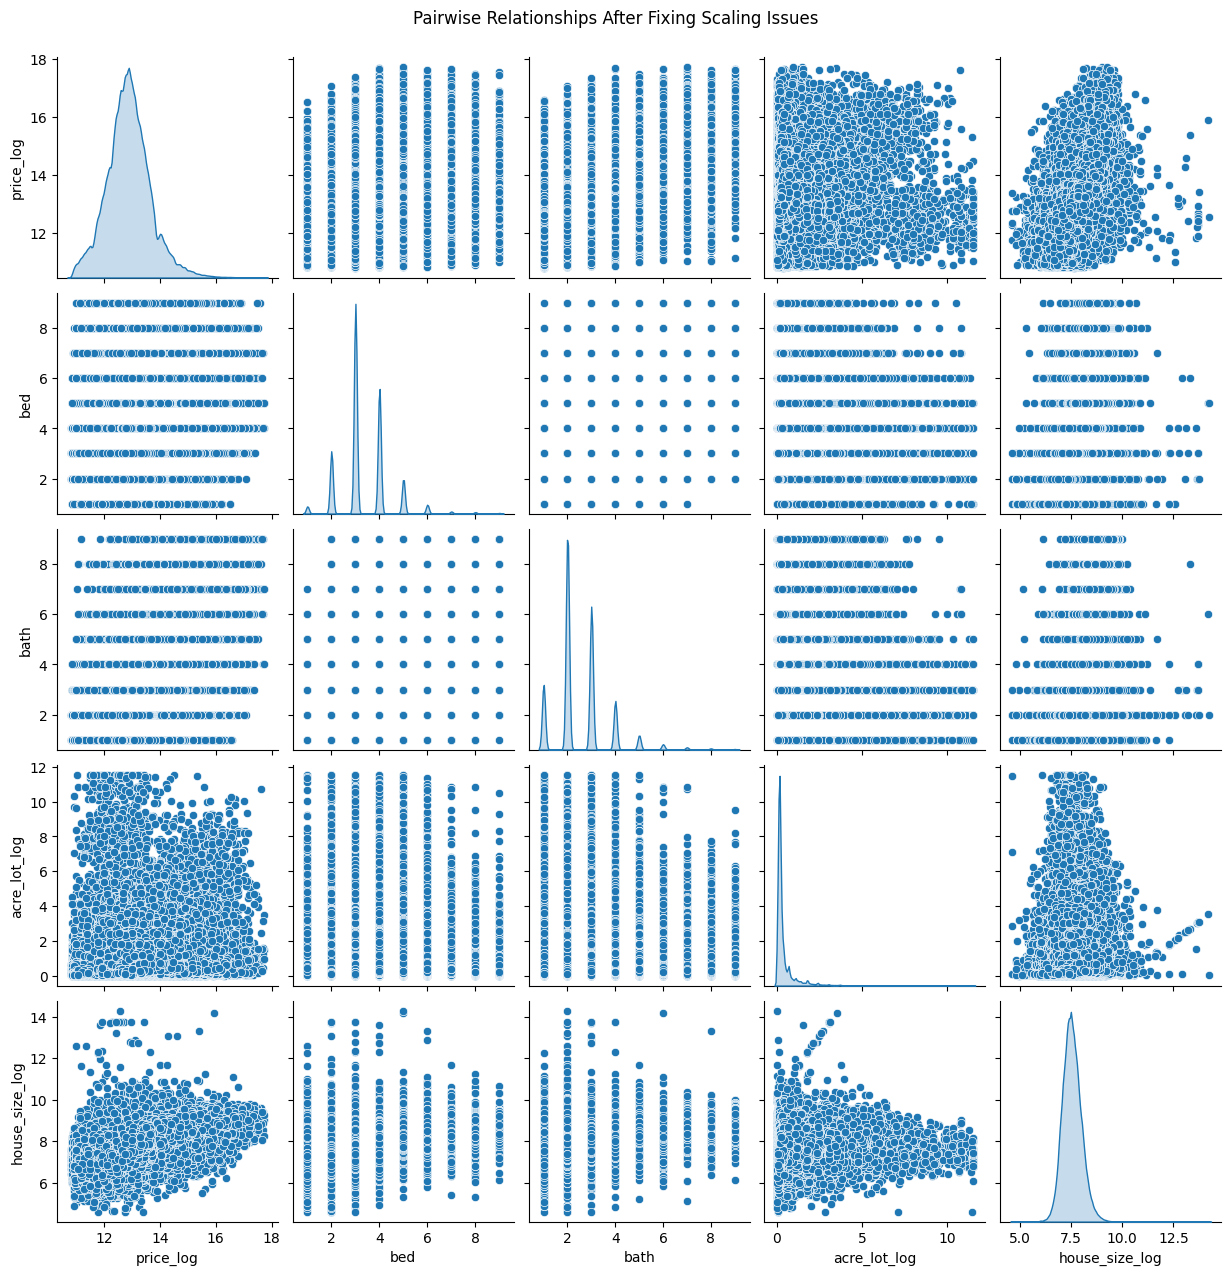

In [127]:
# Apply Log to handle scaling issues
df_plot = df[:]
df_plot['price_log'] = np.log1p(df['price'])
df_plot['house_size_log'] = np.log1p(df['house_size'])
df_plot['acre_lot_log'] = np.log1p(df['acre_lot'])

sns.pairplot(
    df_plot, 
    vars=['price_log', 'bed', 'bath', 'acre_lot_log', 'house_size_log'], 
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships After Fixing Scaling Issues', y=1.02)
plt.show()

In [128]:
# Save the cleaned dataset
df.to_csv('datasets/realtordataUS_cleaned.csv', index=False)

## Data Preproccessing

In [129]:
df_cleaned = pd.read_csv('datasets/realtordataUS_cleaned.csv', encoding='UTF-8')
df_cleaned

,price,bed,bath,acre_lot,city,state,zip_code,house_size
0,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
1,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0
2,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0
3,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0
4,179000.0,4.0,3.0,0.46,San Sebastian,Puerto Rico,612.0,2520.0
...,...,...,...,...,...,...,...,...
1239180,359900.0,4.0,2.0,0.33,Richland,Washington,99354.0,3600.0
1239181,350000.0,3.0,2.0,0.10,Richland,Washington,99354.0,1616.0
1239182,440000.0,6.0,3.0,0.50,Richland,Washington,99354.0,3200.0
1239183,179900.0,2.0,1.0,0.09,Richland,Washington,99354.0,933.0


Due to our computation limit, we will only use 43000 entries from state California

In [145]:
df_single_state = df_cleaned[df_cleaned['state'] == 'California']
df_single_state_sample = df_single_state.sample(n=100)
df_single_state_remaining = df_single_state.drop(df_single_state_sample.index)
df_single_state_remaining.to_csv('datasets/realtordataUS_cleaned_california_remaining.csv', index=False)
df_single_state_sample

,price,bed,bath,acre_lot,city,state,zip_code,house_size
1120164,875000.0,3.0,2.0,0.14,Los Angeles,California,90008.0,1588.0
660651,319990.0,3.0,2.0,0.58,Mountain Center,California,92561.0,1100.0
684356,899000.0,6.0,4.0,0.15,Elk Grove,California,95624.0,3714.0
1179286,2988000.0,4.0,3.0,1.22,Alamo,California,94507.0,2800.0
1199583,290000.0,1.0,2.0,2.32,Placerville,California,95667.0,1242.0
...,...,...,...,...,...,...,...,...
667925,429900.0,3.0,2.0,0.26,Chowchilla,California,93610.0,2023.0
1172729,1488000.0,4.0,2.0,0.13,Fremont,California,94536.0,1830.0
659272,525555.0,3.0,1.0,0.18,Riverside,California,92506.0,1050.0
1129398,775000.0,3.0,2.0,0.14,Buena Park,California,90620.0,1498.0


First, we should normalize our numeric features because the values range vastly across the dataset. This will ensure our data is on similar scales and this could improve our models performance down the line.

In [131]:
# Use RobustScaler to less sensitive to outliers
scaler = RobustScaler()

# Normalize numerical features, using the whole California dataset to cover a larger range
numerical_features_to_scale = ['bed', 'bath', 'acre_lot', 'house_size']
scaler.fit(df_single_state[numerical_features_to_scale])

# Transform sample data
df_single_state_sample_normalized = df_single_state_sample[:]
df_single_state_sample_normalized[numerical_features_to_scale] = scaler.transform(df_single_state_sample_normalized[numerical_features_to_scale])
df_single_state_sample_normalized

,price,bed,bath,acre_lot,city,state,zip_code,house_size
1181644,850000.0,0.0,0.0,-0.352941,Livermore,California,94551.0,0.044221
662940,559990.0,1.0,1.0,0.235294,Kingsburg,California,93631.0,0.840201
631149,1719000.0,0.0,0.0,3.352941,Playa Vista,California,90094.0,-0.062312
1195331,358000.0,0.0,0.0,-0.176471,Sacramento,California,95822.0,-0.389950
672987,875000.0,-2.0,-1.0,0.000000,San Francisco,California,94114.0,-0.780905
...,...,...,...,...,...,...,...,...
1180508,1825000.0,0.0,1.0,2.117647,Walnut Creek,California,94595.0,0.226131
669247,375000.0,0.0,0.0,10.647059,Coarsegold,California,93614.0,0.149749
1132074,999000.0,1.0,0.0,0.176471,San Pedro,California,90732.0,-0.326633
636871,842000.0,1.0,0.0,0.058824,Garden Grove,California,92840.0,-0.316583


Next, we convert the categorical location data (city, state, zip code) into numerical data. There is also an option to use Embedding layers, however that will limit our prediction inputs (since the categorical data of this dataset is not fixed)

In [132]:
# Merge city, state, and zip_code into a location string for GeoPy API to convert to longitude and latitude coordinates
df_single_state_sample_normalized['zip_code'] = df_single_state_sample_normalized['zip_code'].astype(int)
df_single_state_sample_normalized['location'] = df_single_state_sample_normalized['city'] + ', ' + df_single_state_sample_normalized['state'] + ', ' + df_single_state_sample_normalized['zip_code'].astype(str)
df_single_state_sample_normalized

,price,bed,bath,acre_lot,city,state,zip_code,house_size,location
1181644,850000.0,0.0,0.0,-0.352941,Livermore,California,94551,0.044221,"Livermore, California, 94551"
662940,559990.0,1.0,1.0,0.235294,Kingsburg,California,93631,0.840201,"Kingsburg, California, 93631"
631149,1719000.0,0.0,0.0,3.352941,Playa Vista,California,90094,-0.062312,"Playa Vista, California, 90094"
1195331,358000.0,0.0,0.0,-0.176471,Sacramento,California,95822,-0.389950,"Sacramento, California, 95822"
672987,875000.0,-2.0,-1.0,0.000000,San Francisco,California,94114,-0.780905,"San Francisco, California, 94114"
...,...,...,...,...,...,...,...,...,...
1180508,1825000.0,0.0,1.0,2.117647,Walnut Creek,California,94595,0.226131,"Walnut Creek, California, 94595"
669247,375000.0,0.0,0.0,10.647059,Coarsegold,California,93614,0.149749,"Coarsegold, California, 93614"
1132074,999000.0,1.0,0.0,0.176471,San Pedro,California,90732,-0.326633,"San Pedro, California, 90732"
636871,842000.0,1.0,0.0,0.058824,Garden Grove,California,92840,-0.316583,"Garden Grove, California, 92840"


Convert location string to longitude and latitude coordinates

In [133]:
geolocator = Nominatim(user_agent='ontariotechu')

def get_long_lat_coordinates(location):
    try:
        loc = geolocator.geocode(location)
        if loc:
            return loc.latitude, loc.longitude
        else:
            return None, None
    except Exception as e:
        return None, None

df_single_state_sample_longlat = df_single_state_sample_normalized[:]
df_single_state_sample_longlat[['loc_lat', 'loc_long']] = df_single_state_sample_longlat.apply(lambda row: pd.Series(get_long_lat_coordinates(row['location'])), axis=1)
df_single_state_sample_longlat.to_csv('datasets/realtordataUS_cleaned_california_sample.csv', index=False)
df_single_state_sample_longlat

,price,bed,bath,acre_lot,city,state,zip_code,house_size,location,loc_lat,loc_long
1181644,850000.0,0.0,0.0,-0.352941,Livermore,California,94551,0.044221,"Livermore, California, 94551",37.682058,-121.768053
662940,559990.0,1.0,1.0,0.235294,Kingsburg,California,93631,0.840201,"Kingsburg, California, 93631",36.513840,-119.553893
631149,1719000.0,0.0,0.0,3.352941,Playa Vista,California,90094,-0.062312,"Playa Vista, California, 90094",33.976010,-118.418165
1195331,358000.0,0.0,0.0,-0.176471,Sacramento,California,95822,-0.389950,"Sacramento, California, 95822",38.581061,-121.493895
672987,875000.0,-2.0,-1.0,0.000000,San Francisco,California,94114,-0.780905,"San Francisco, California, 94114",37.779259,-122.419329
...,...,...,...,...,...,...,...,...,...,...,...
1180508,1825000.0,0.0,1.0,2.117647,Walnut Creek,California,94595,0.226131,"Walnut Creek, California, 94595",37.902073,-122.061870
669247,375000.0,0.0,0.0,10.647059,Coarsegold,California,93614,0.149749,"Coarsegold, California, 93614",37.262169,-119.700983
1132074,999000.0,1.0,0.0,0.176471,San Pedro,California,90732,-0.326633,"San Pedro, California, 90732",33.735852,-118.292293
636871,842000.0,1.0,0.0,0.058824,Garden Grove,California,92840,-0.316583,"Garden Grove, California, 92840",33.774629,-117.946372


Then we have to convert longitude and latitude coordinates to the Earth's Cartesian coordinates, so that our model can do spatial calculation

In [134]:
df_single_state_sample_cartesian = df_single_state_sample_longlat[:]

# Convert latitude and longitude to radians
df_single_state_sample_cartesian['loc_lat_rad'] = np.radians(df_single_state_sample_cartesian['loc_lat'])
df_single_state_sample_cartesian['loc_long_rad'] = np.radians(df_single_state_sample_cartesian['loc_long'])

# Calculate Cartesian coordinates
df_single_state_sample_cartesian['loc_x'] = np.cos(df_single_state_sample_cartesian['loc_lat_rad']) * np.cos(df_single_state_sample_cartesian['loc_long_rad'])
df_single_state_sample_cartesian['loc_y'] = np.cos(df_single_state_sample_cartesian['loc_lat_rad']) * np.sin(df_single_state_sample_cartesian['loc_long_rad'])
df_single_state_sample_cartesian['loc_z'] = np.sin(df_single_state_sample_cartesian['loc_lat_rad'])

# Now we can remove all categorical columns and intermediate math columns
df_single_state_sample_processed = df_single_state_sample_cartesian.drop(columns=['city', 'state', 'zip_code', 'location', 'loc_lat', 'loc_long', 'loc_lat_rad', 'loc_long_rad'])
df_single_state_sample_processed # The Cartesian data is already normalized

,price,bed,bath,acre_lot,house_size,loc_x,loc_y,loc_z
1181644,850000.0,0.0,0.0,-0.352941,0.044221,-0.416666,-0.672850,0.611279
662940,559990.0,1.0,1.0,0.235294,0.840201,-0.396425,-0.699144,0.595017
631149,1719000.0,0.0,0.0,3.352941,-0.062312,-0.394653,-0.729343,0.558846
1195331,358000.0,0.0,0.0,-0.176471,-0.389950,-0.408380,-0.666575,0.623621
672987,875000.0,-2.0,-1.0,0.000000,-0.780905,-0.423730,-0.667194,0.612621
...,...,...,...,...,...,...,...,...
1180508,1825000.0,0.0,1.0,2.117647,0.226131,-0.418861,-0.668710,0.614314
669247,375000.0,0.0,0.0,10.647059,0.149749,-0.394334,-0.691314,0.605463
1132074,999000.0,1.0,0.0,0.176471,-0.326633,-0.394156,-0.732264,0.555365
636871,842000.0,1.0,0.0,0.058824,-0.316583,-0.389552,-0.734298,0.555928


Now we need to seperate features as well as targets in order to utilize PyTorch. So we complete the following:

In [135]:
# Separate features and target
X = df_single_state_sample_processed.drop(columns=['price'])
y = df_single_state_sample_processed['price']

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.int64)

# Create TensorDataset and DataLoaders
dataset = TensorDataset(X_tensor, y_tensor)

Finally we can split the data into training and testing sets, and we can prepare a dataloader. This ensures we can use batching which will also help performance.

In [136]:
# Split into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [137]:
def evaluate(model):
    accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=3)
    x, y_exp = dataset[:]
    y = model(x)
    return accuracy(y, y_exp)

In [138]:
class LinearClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        # define the `nn` as the neural network. In this case, it
        # should be a simple nn.Linear(...) layer.
        self.nn = nn.Linear(4, 3)
        
        # define the loss function to be used.
        # It should be nn.CrossEntropyLoss(...)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, batch):
        # return the output which should be
        # a 3D vector corresponding to the logits of the
        # three class predictions.
        return self.nn(batch)
    
    def training_step(self, batch):
        # - The batch is a tuple (x, targets), where
        #   x is the input vectors, and targets the integer labels.
        # - return the loss value for the current batch.
        # - the loss is computed using forward(...) and loss_fn(...)
        x, targets = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, targets)
        return loss
    
    def configure_optimizers(self):
        # returns an optimizer that is configured to
        # optimize `self.parameters()`.
        # Use the optim.Adam(...)
        return optim.Adam(self.parameters(), lr=0.01)

In [139]:
class MLP(LinearClassifier):
    def __init__(self, hidden:int):
        super().__init__()
        self.nn = nn.Sequential(
            # linear layer
            nn.Linear(4, hidden),
            # ReLU
            nn.ReLU(),
            # output linear layer
            nn.Linear(hidden, 3)
        )

In [140]:
# torchinfo.summary(MLP(10))

In [141]:
# torch.manual_seed(0)
# model = MLP(10)
# trainer = L.Trainer(max_epochs=10)

# trainer.fit(model, train_dataloaders=dataloader)

In [142]:
# evaluate(model)

In [143]:
# import onnx

# model.eval()
# torch.onnx.export(
#     model,
#     torch.randn(1, 4),
#     "../deploy/my_model.onnx",
#     export_params=True,
#     opset_version=11,
#     input_names=["input"],
#     output_names=["output"],
#     dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
# )